# Финальный проект

## Описание задачи:

На основе характеристик машины, построить модель для предсказания стоимости автомобиля и оценить ее эффективность

In [12]:
!pip install lightgbm

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

from  lightgbm import LGBMRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

In [14]:
data = pd.read_csv('autos.csv')

In [15]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
  
**Целевой признак**
- Price — цена (евро)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [17]:
data['PostalCode'] = data['PostalCode'].astype('object')

Всего в нашем датасете - 354669 записей и 16 колонок. Есть пропущенные значения в нескольких колонках, в большинстве колонок типы данных указаны корректно, кроме тех, что связаны с датой скачивания анкеты из базы и датой последней активности пользователя - их мы не будем использовать при построении моделей, поэтому не будет пока изменять.  

Давайте проведем предобработку данных, проверим есть ли выбросы или некорректные значения внутри наших признаков.

## Предобработка данных

In [18]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0


Мы видим, что есть проблемы с целевым признаком - есть нули. В годе регистрации так же есть явные выбросы и в нижнем пороге - 1000 и в верхнем 9999. Количество лошадинных сил тоже не всегда указано корректно, так например, есть значения с нулем, а есть какие-то слишком больше значения в 20000, хотя у самых мощных автомобилей в мире кол-во л. с. варьирует около 2000. 

Давайте изучим внимательнее признаки, для того, чтобы выбрарь стратегию работы с некорректными значениями

### Целевой признак. Цена

Для начала рассмотрим наш таргет - цену. Посмотрим на распределение

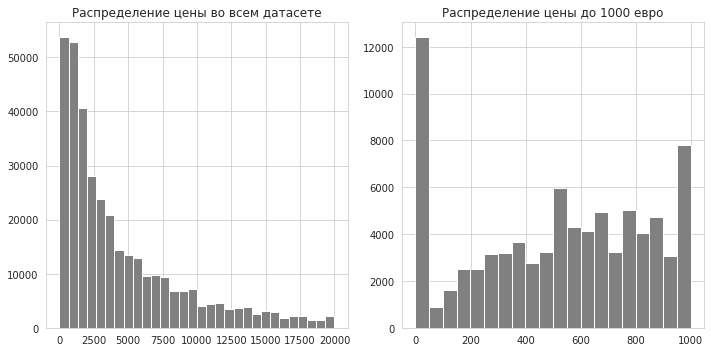

In [19]:
sns.set_style('whitegrid')

fig, axs = plt.subplots(1,2, figsize=(10, 5))

axs[0].hist(data['Price'],bins=30 , color='grey')
axs[1].hist(data[data['Price'] < 1000]['Price'], bins=20, color='grey')

axs[0].set_title('Распределение цены во всем датасете')
axs[1].set_title('Распределение цены до 1000 евро')

plt.tight_layout()
plt.show()

Как мы можем увидеть по гистограммам в нашем датасете достаточно много объектов, у которых цена равна нулю. Скорее всего эти данные не корректны, и могли появиться либо из-за каких-то анкет, которые на самом деле создавались не с целью продажи авто, а например с целью проверки сервиса, либо просто некорректно было заполнено поле цены, либо продавец не хотел публиковать стоимость на сайте.

Помимо нулевых значений, у нас есть также очень маленькая стоимость до 600 евро - можно предположить что это потенциально могли быть машины после серьезных аварий, или просто определенные достаточно дешевые модели. 

In [20]:
data[data['Price'] < 600].sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
280,2016-03-29 23:55:12,590,sedan,1996,manual,0,corsa,150000,0,NaN,opel,NaN,2016-03-29 00:00:00,0,32052,2016-04-06 21:18:19
324417,2016-03-15 11:50:51,500,wagon,1997,auto,150,NaN,150000,7,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,29410,2016-03-15 11:50:51
182848,2016-03-30 15:50:09,450,sedan,1988,manual,55,golf,150000,8,petrol,volkswagen,no,2016-03-30 00:00:00,0,51580,2016-04-01 10:17:54
130177,2016-03-17 22:42:37,1,wagon,1996,manual,0,e_klasse,5000,0,petrol,mercedes_benz,NaN,2016-03-17 00:00:00,0,50667,2016-04-07 13:17:31
303805,2016-04-03 16:48:29,0,small,1997,manual,75,other,150000,0,petrol,toyota,NaN,2016-04-03 00:00:00,0,41515,2016-04-03 16:48:29
194954,2016-03-23 16:59:26,350,wagon,1996,manual,115,NaN,150000,0,petrol,volkswagen,NaN,2016-03-23 00:00:00,0,8132,2016-03-26 10:46:12
160465,2016-03-14 12:36:24,500,coupe,1995,auto,0,3er,150000,6,petrol,bmw,NaN,2016-03-14 00:00:00,0,39124,2016-04-05 11:50:24
305112,2016-03-15 13:41:12,500,sedan,1997,manual,0,corsa,150000,1,petrol,opel,NaN,2016-03-15 00:00:00,0,67574,2016-03-15 13:41:12
43959,2016-03-20 13:42:49,250,small,1995,manual,45,NaN,150000,9,petrol,opel,yes,2016-03-20 00:00:00,0,44653,2016-03-24 05:15:46
67703,2016-03-15 12:36:43,400,NaN,2000,manual,75,golf,150000,0,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,31855,2016-03-17 06:16:59


In [21]:
data[data['Price'] < 600].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
count,46326.000000,46326.000000,46326.000000,46326.000000,46326.000000,46326.0
mean,267.101282,2003.778915,68.877542,131994.020636,4.230087,0.0
std,204.138224,185.403448,183.097878,40999.526762,3.978465,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1.000000,1996.000000,0.000000,150000.000000,0.000000,0.0
50%,299.500000,1998.000000,60.000000,150000.000000,4.000000,0.0
75%,450.000000,2001.000000,100.000000,150000.000000,7.000000,0.0
max,599.000000,9999.000000,15016.000000,150000.000000,12.000000,0.0


Да, в принципе, мы видим что в основном это достаточно старые машины - медиана 1998 год

In [22]:
shape = data[data['Price'] < 50].shape[0]
print(f'Всего объектов с ценой меньше 50 евро: {shape}')
data[data['Price'] < 50].isnull().mean()

Всего объектов с ценой меньше 50 евро: 12423


Мне кажется, что нет смысла пытаться востановить реальную стоимость этих машин - всего строчек с ценой меньше 50 евро **12423**. 

Во-первых, там достаточно много пропусков в таких категориальных переменных, которые потенциально могли бы помочь в определении рыночной стоимости, а во-вторых, даже если бы мы их восстановили, непонятно, насколько удачно нам бы удалось это сделать и не повредили ли бы наши расчеты будущим алгоритмам предсказания. 

**Поэтому предлагаю далее обрабатывать данные и строить модели без наблюдений с ценой до 50 евро.**

In [23]:
data_without_null = data[data['Price'] > 50]

In [24]:
data_without_null.shape

(341619, 16)

### RegistrationYear

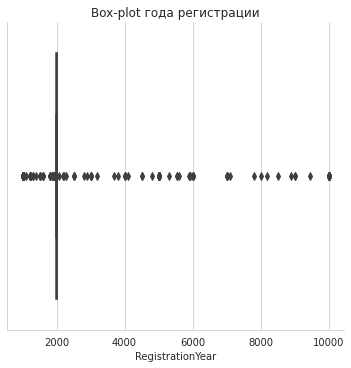

In [25]:
sns.catplot(x='RegistrationYear', data=data_without_null, kind='box')
plt.title('Box-plot года регистрации')
plt.show()

Несмотря на то, что наиболее часто встречающиеся года регистрации оказываются около 2000 года - как и требовалось ожидать, в датасете есть множество ошибочных значений - старше 2020 года, что физически не может быть возможным. Давайте с помощью условий, посмотрим сколько объектов с некорректно установленной датой регистрации и есть ли какие-то отличительные особенности, которые помогут нам восстановить эти значения.

In [26]:
condition = (data_without_null['RegistrationYear'] > 2022) | (data_without_null['RegistrationYear'] < 1850)
data_without_null[condition]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15870,2016-04-02 11:55:48,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-04-02 00:00:00,0,33649,2016-04-06 09:46:13
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
17271,2016-03-23 16:43:29,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN,2016-03-23 00:00:00,0,21769,2016-04-05 20:16:15
17346,2016-03-06 16:06:20,6500,NaN,8888,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-06 00:00:00,0,55262,2016-03-30 20:46:55
18224,2016-03-09 17:49:44,7999,NaN,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328453,2016-03-14 18:54:32,450,NaN,2500,NaN,0,6_reihe,5000,0,NaN,mazda,NaN,2016-03-14 00:00:00,0,45475,2016-03-19 07:17:39
331753,2016-03-28 19:39:11,99,NaN,9999,NaN,0,1er,10000,0,NaN,bmw,NaN,2016-03-28 00:00:00,0,1239,2016-04-07 01:45:47
334967,2016-03-20 17:53:51,12000,NaN,4000,NaN,500,golf,5000,0,NaN,volkswagen,no,2016-03-20 00:00:00,0,57392,2016-04-07 00:46:30
340759,2016-04-04 23:55:47,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0,86343,2016-04-05 06:44:07


Так как значений не очень много - 124, и в них много пропусков и в категориальных и в количественных переменных - я пердлагаю просто убрать их из датасета. 

In [27]:
condition = (data_without_null['RegistrationYear'] > 2022) | (data_without_null['RegistrationYear'] < 1850)
data_without_null = data_without_null.drop(data_without_null[condition].index)

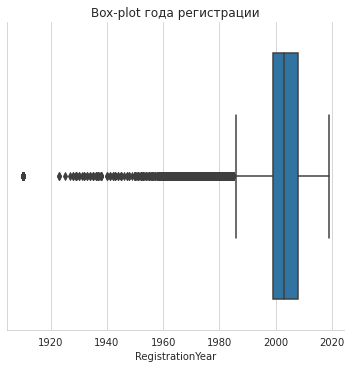

In [28]:
sns.catplot(x='RegistrationYear', data=data_without_null, kind='box')
plt.title('Box-plot года регистрации')
plt.show()

### Power

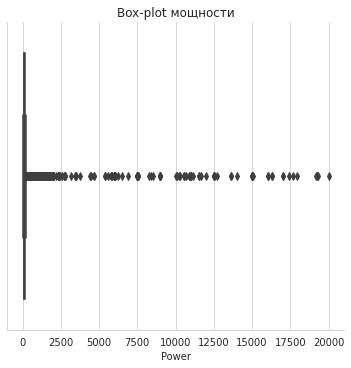

In [29]:
sns.catplot(x='Power', data=data_without_null, kind='box')
plt.title('Box-plot мощности')
plt.show()

In [30]:
data_without_null['Power'].describe()

В данных с показателями мощности также есть ряд проблем, например, есть нулевые показатели, и очень большие значения вроде 20000 - последнее скорее всего не просто выброс, а именно некорректное значение, т. к. кол-во лошадинных сил у самых мощных машин находится около 2000 л. с., и соответсвенно наше максимальное значение очень сильно превышает данный показатель, что говорит о фактической невероности. 

In [31]:
data_without_null[data_without_null['Power'] < 5]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23


In [32]:
data_without_null[data_without_null['Power'] > 1500]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
9664,2016-03-14 20:06:19,2599,NaN,2016,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14 00:00:00,0,60326,2016-04-07 09:45:27
9875,2016-03-31 20:51:13,550,wagon,2003,manual,1753,focus,150000,1,gasoline,ford,yes,2016-03-31 00:00:00,0,21039,2016-03-31 20:51:13
19092,2016-03-20 17:54:04,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no,2016-03-20 00:00:00,0,21376,2016-03-23 02:48:53
20050,2016-03-26 19:46:06,2200,sedan,2002,auto,1704,e_klasse,150000,1,NaN,mercedes_benz,yes,2016-03-26 00:00:00,0,31812,2016-04-06 09:44:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348137,2016-03-16 21:48:39,850,sedan,1993,auto,9012,golf,150000,0,petrol,volkswagen,NaN,2016-03-16 00:00:00,0,14482,2016-04-03 09:17:43
348237,2016-04-04 12:38:11,3000,coupe,2007,manual,2007,corsa,150000,3,gasoline,opel,yes,2016-04-04 00:00:00,0,72218,2016-04-04 12:38:11
348668,2016-03-05 17:53:09,1000,wagon,1996,manual,2598,a6,150000,7,NaN,audi,NaN,2016-03-05 00:00:00,0,7646,2016-03-07 16:17:01
348883,2016-03-13 11:51:57,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,NaN,2016-03-13 00:00:00,0,24568,2016-04-06 15:17:39


Давайте заполним значения мощности, которые меньше пяти и больше 1500 медианными значениями по групперовке по типу транспортного средства, модели и бренду. Так, как не у всех моделей заполненны все три признака, оставшиеся заполним группировкой просто по типу и модели, по модели и бренду, и последние оставшиеся по цене и бренду. 

In [33]:
def power(groupby):
    data_without_null['Power'].fillna(data_without_null.groupby(groupby)['Power'].transform('median'),inplace=True)
    return data_without_null

In [34]:
data_without_null.loc[(data_without_null['Power'] < 5) | (data_without_null['Power'] > 1500), 'Power'] = np.nan


data_without_null = power(['VehicleType', 'Model', 'Brand'])
data_without_null = power(['VehicleType', 'Brand'])
data_without_null = power([ 'Model', 'Brand'])
data_without_null = power(['Brand','Price'])

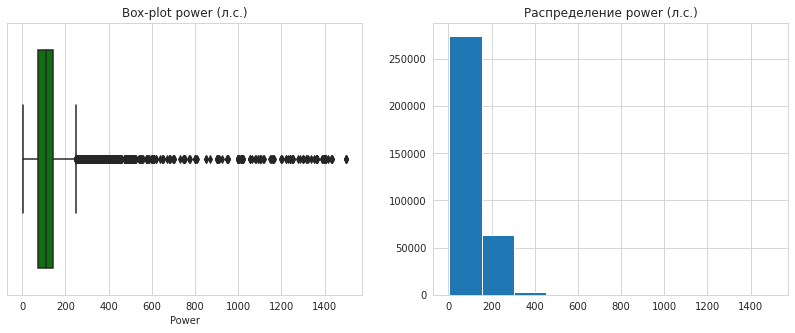

In [35]:
fig, axs = plt.subplots(1,2, figsize=(14,5))

sns.boxplot(x='Power', data=data_without_null, ax=axs[0], color='green')

axs[1].hist(x='Power', data=data_without_null)

axs[0].set_title('Box-plot power (л.c.)')
axs[1].set_title('Распределение power (л.c.)')
plt.show()

Теперь мы получили более правдаподобное распределение. Давайте проверим, не потеряли ли мы какие-то значения мощностей

In [36]:
data_without_null.isnull().sum()

88 значений так и не заполнились через группировку. Давайте посмотрим на них. 

In [37]:
data_without_null[data_without_null['Power'].isnull()].sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
241917,2016-03-22 01:50:55,4680,NaN,2006,auto,NaN,NaN,50000,12,gasoline,sonstige_autos,no,2016-03-21 00:00:00,0,42799,2016-04-05 15:17:44
338158,2016-04-02 19:47:13,2977,NaN,2018,auto,NaN,NaN,125000,11,lpg,audi,no,2016-04-02 00:00:00,0,78234,2016-04-02 19:47:13
20860,2016-03-20 13:59:51,2398,NaN,2017,auto,NaN,NaN,150000,9,petrol,mercedes_benz,no,2016-03-20 00:00:00,0,95100,2016-03-28 12:47:29
6977,2016-03-24 08:37:22,135,NaN,1910,NaN,NaN,NaN,5000,0,NaN,opel,NaN,2016-03-24 00:00:00,0,19374,2016-04-06 20:46:08
177407,2016-03-19 13:45:14,298,NaN,1980,auto,NaN,NaN,150000,1,petrol,sonstige_autos,yes,2016-03-19 00:00:00,0,74749,2016-04-04 17:18:49
16741,2016-03-21 00:58:22,160,NaN,2007,NaN,NaN,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,90766,2016-04-05 22:45:47
153478,2016-03-10 17:45:33,60,NaN,2000,NaN,NaN,NaN,5000,0,NaN,fiat,NaN,2016-03-10 00:00:00,0,45770,2016-03-11 05:44:54
28908,2016-03-14 07:58:52,5700,NaN,1960,NaN,NaN,NaN,100000,0,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,36043,2016-04-07 08:16:19
179347,2016-03-25 11:43:04,1749,NaN,2017,NaN,NaN,NaN,70000,0,NaN,honda,NaN,2016-03-25 00:00:00,0,86154,2016-03-30 00:17:06
304618,2016-03-29 20:41:07,866,NaN,2000,NaN,NaN,NaN,150000,0,NaN,mitsubishi,NaN,2016-03-29 00:00:00,0,97072,2016-03-31 14:16:05


Заполним их медианной по бренду. 

In [38]:
data_without_null = power('Brand')

In [39]:
data_without_null.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
count,341495.000000,341495.000000,341495.000000,341495.000000,341495.000000,341495.0
mean,4581.900461,2003.202305,119.172051,128515.424823,5.795915,0.0
std,4514.718981,7.318521,56.730807,37227.119306,3.690732,0.0
min,55.000000,1910.000000,5.000000,5000.000000,0.000000,0.0
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000,0.0
50%,2900.000000,2003.000000,110.000000,150000.000000,6.000000,0.0
75%,6500.000000,2008.000000,144.000000,150000.000000,9.000000,0.0
max,20000.000000,2019.000000,1500.000000,150000.000000,12.000000,0.0


Через описательные статистики, мы видим, что мы избавились от многих фактически некорректных зачений, и теперь наши количественные показатели больше походят на действительные характеристики машин. Перейдем к работе с категориальными переменными

### Категориальные переменные

Достаточно много пропусков в категориальных переменных - VehicleType, Gearbox, Model, FuelType, NotRepaired

In [40]:
data_without_null.VehicleType.value_counts(dropna=False)

Самыми популярными типами транспортного средства оказались: седан, small? и фургон?. 

Следуйший по частоте тип - это пропуски, всего их здесь 32730. Я предлагаю посмотреть, как обстоят дела с пропущенными значениями в других категориях и относительно этого решить, избавлятся ли от них/заполнять чем-то или рассматривать nan как отдельную категорию

In [41]:
data_without_null.Gearbox.value_counts(normalize=True, dropna=False)

В типе коробки передач преобладает - ручная. Nan занимают лишь около 5% ответов

In [42]:
data_without_null.Model.value_counts(dropna=False, normalize=True)

Из-за того, что категорий достаточно много 251, каждая категория не занимает больше процента от общего числа. Хотя относительно остальных значений Nan получает достаточно большую долю - 0.05

In [43]:
data_without_null.FuelType.value_counts(dropna=False, normalize=True)

Насколько мне известно petrol и gasoline используются как синонимы, поэтому мы можем сказать, что 88% машин использовали бензин. Nan занимают в этом признаке 8 процентов

In [44]:
data_without_null.NotRepaired.value_counts(dropna=False, normalize=True)

Для того, чтобы узнать что делать с Nan, предлагаю проверить такую гипотезу. Отсуствие информации о перечисленных ывше признаков влияет на итоговую стоимость машины. Давайте для этого построим гистограммы. 

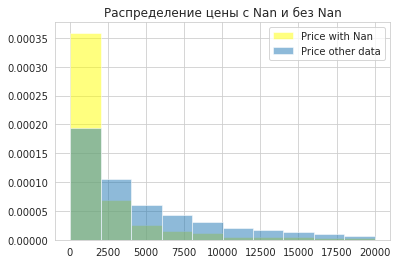

In [45]:
data_without_nan = data_without_null[ ~ (data_without_null['Model'].isnull()) & ~ (data_without_null['Gearbox'].isnull())]
nan = data_without_null[(data_without_null['Model'].isnull()) & (data_without_null['Gearbox'].isnull())]

fig, ax = plt.subplots()

ax.hist(nan['Price'], density=True, alpha=0.5, color='yellow', label='Price with Nan')
ax.hist(data_without_nan['Price'],density=True, alpha=0.5, label='Price other data')


ax.legend()
ax.set_title('Распределение цены с Nan и без Nan')

plt.show()

По гистограмме мы видим, что объекты с пропущенными полями в категориальных признаках стоят меньше. Давайте возьмем Nan, как отдельную категорию для того, чтобы сохранить эту тенденцию при построеним модели.

In [46]:
data_without_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341495 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        341495 non-null  object 
 1   Price              341495 non-null  int64  
 2   VehicleType        308775 non-null  object 
 3   RegistrationYear   341495 non-null  int64  
 4   Gearbox            325046 non-null  object 
 5   Power              341495 non-null  float64
 6   Model              324433 non-null  object 
 7   Kilometer          341495 non-null  int64  
 8   RegistrationMonth  341495 non-null  int64  
 9   FuelType           313009 non-null  object 
 10  Brand              341495 non-null  object 
 11  NotRepaired        276911 non-null  object 
 12  DateCreated        341495 non-null  object 
 13  NumberOfPictures   341495 non-null  int64  
 14  PostalCode         341495 non-null  object 
 15  LastSeen           341495 non-null  object 
dtypes:

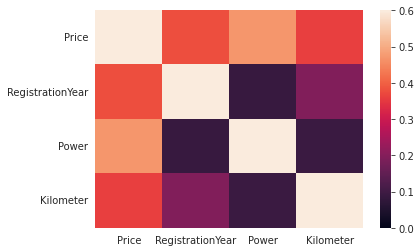

In [47]:
corr_col = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
c= data_without_null[corr_col].corr()
sns.heatmap(np.abs(c), vmin=0, vmax=0.6)
plt.show()

## Модели

In [48]:
features = data_without_null.drop(['Price', 'RegistrationMonth', 'DateCreated', 
                                    'DateCrawled', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1)
target = data_without_null['Price']

In [49]:
f_train, f_test_valid, t_train, t_test_valid = train_test_split(features, 
                                                    target, 
                                                    test_size=.4, 
                                                    random_state=12345)

f_test, f_valid, t_test, t_valid = train_test_split(f_test_valid, 
                                                    t_test_valid, 
                                                    test_size=.5, 
                                                    random_state=12345)

print(f_train.shape, f_test.shape, f_valid.shape, t_train.shape)

(204897, 9) (68299, 9) (68299, 9) (204897,)


In [50]:
numerical = ['RegistrationYear', 'Power',
            'Kilometer']

categorical = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired']

In [51]:
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(sparse=False, drop='first', handle_unknown = "ignore"))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit column transformer to training data
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

В пайплайнах прописываем для количественных переменных: заполнение nanов медианной, и масштабирование. Для количественных: OneHotEncoder c игнорирование ошибок, так как потенциально в будущих данных могут появляться модели/бредны, которых не было в исторических данных на которых модель обучалась

### Градиентный бустинг

In [52]:
pipe = Pipeline([('preprocessing', preprocessor), ('model', LGBMRegressor())])

param_grid = [
{'model': [LGBMRegressor()], 'preprocessing': [preprocessor],
    'model__max_depth': [4,6,8], 
    'model__num_leaves': [16, 64, 256]}] 

In [123]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error', error_score="raise")
grid.fit(f_train, t_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best params:
{'model': LGBMRegressor(max_depth=8, num_leaves=256), 'model__max_depth': 8, 'model__num_leaves': 256, 'preprocessing': ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['VehicleType', 'Gearbox', 'Model', 'FuelType',
                                  'Brand', 'NotRepaired']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['RegistrationYear', 'Power', 'Kilometer'])])}

Best cross-validation score:

In [125]:
print("Test-set score: {:.2f}".format(grid.score(f_test, t_test)))

Test-set score: -1680.12


### Линейная регрессия

In [126]:
pipe_liner = Pipeline([('preprocessing', preprocessor), ('model', LinearRegression())])
pipe_liner.fit(f_train, t_train)


score = cross_val_score(pipe_liner, f_train, t_train, scoring='neg_root_mean_squared_error', cv=5)
print('Кросс-валидация на линейной регресии',score.mean())

Кросс-валидация на линейной регресии -2706.645507309285


In [127]:
predict_liner = pipe_liner.predict(f_test)
print('Оценка линейной регрессии на тесте: ', mean_squared_error(t_test, predict_liner, squared=False))

Оценка линейной регрессии на тесте:  2715.0624659818955


Линейная регрессия показывает результат значительно хуже, чем градиентый бустинг. Давайте проверим оценки моделей в сравнении с моделью предсказывающую медиану. 

### Dummy

In [53]:
dummy_regressor = DummyRegressor(strategy="median")
dummy_regressor.fit(f_train, t_train)
dummy_pred = dummy_regressor.predict(f_test)
RMSE_dummy_rougher = mean_squared_error(t_test, dummy_pred, squared=False)
print('Оценка дамми регрессии на тесте:', RMSE_dummy_rougher) 

Оценка дамми регрессии на тесте: 4823.5690917616475


### Вывод

И линейная регрессия и градиентный бустинг, справляюстя с задачей значительно лучше чем дамми-модель. Однако, ошибка в 1600-3000 евро кажется достаточно значительной для сервиса по оценке рыночной стоимости.

## Сравнение моделей

In [55]:
%%time 

pipe_liner = Pipeline([('preprocessing', preprocessor), ('model', LinearRegression())])
pipe_liner.fit(f_train, t_train)
predict_liner = pipe_liner.predict(f_test)

CPU times: user 10 s, sys: 2.55 s, total: 12.6 s
Wall time: 8.72 s


In [57]:
%%time

pipe = Pipeline([('preprocessing', preprocessor), ('model', LGBMRegressor(max_depth=8, num_leaves=256))])
pipe.fit(f_train, t_train)
pipe = pipe.predict(f_test)

CPU times: user 30.3 s, sys: 2.76 s, total: 33.1 s
Wall time: 25.5 s


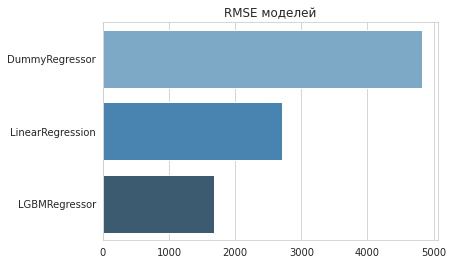

In [66]:
model = ['DummyRegressor', 'LinearRegression', 'LGBMRegressor']
score = [4823, 2715, 1680]
time = [8.72, 25.5]

sns.barplot(x=score, y=model, orient='h', palette="Blues_d")
plt.title('RMSE моделей')

plt.show()

# Итог

Несмотря на то, что модель градиентного бустинга работает дольше, она показывает результат значительно лучше, чем линейная модель. Так как разница между RMSE значительная около 1000 евро - на мой взгляд, лучше использовать модель градиентного бустинга, так как разброс в оценке +- 3000 евро выглядит совсем обескураживающим. Для улучшения моделей, можно более тщательно поработать с историческими данными, в них было много некорректных значений, выбросов и пропусков, возможно более тщательная работа с этими проблема поможет улучшить качество моделей. 